In [331]:
import numpy as np
import pandas as pd

import networkx as nx

%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from trmf import TRMFRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import scipy.sparse as sp


import catboost
import pandas as pd
import numpy as np
from typing import List
import pandas as pd
from scipy import stats
import datetime
import random

import rpy2
from functools import reduce
from catboost import CatBoostRegressor
import math
import trmf
import time
import seaborn as sns
import ast
import numpy as np
from dateutil import parser
from kshape.core import kshape, zscore
from tslearn.clustering import KShape
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import catboost

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
import time
import pickle
import warnings
warnings.filterwarnings("ignore")


In [317]:
# Path fo import files
#input data
import_data = "import/ecs_series_1_uid_encoded(1).csv"
#generated data
transformed_analyzed_data = 'Export/alibaba/alibaba_initial_time_series_2000.csv'
monetary_time_series = "Export/alibaba/alibaba_monetary_2000.csv"
frequency_time_series = "Export/alibaba/alibaba_frequency_2000.csv"
recency_time_series = "Export/alibaba/alibaba_recency_2000.csv"
cluster_centroids_time_series = "Export/alibaba/alibaba_cluster_centroids_2000.csv"
#prediction
prediction_path = "Export/alibaba/alibaba_prediction_trmf_variantA.csv"
#Clusters
import_clusters = "clusters/results_alibaba.csv"

### 0. Preprocessing alibaba + normalizing

In [329]:
df = pd.read_csv(import_data)

In [174]:
# Normalizing
demand = df[['ds', "uid", "vcpu_net_delead"]].\
                    groupby(['ds','uid', "vcpu_net_delead"]).sum().\
                    reset_index()
df['vcpu_net_delead'] = demand[["uid","vcpu_net_delead"]].\
                    groupby(["uid"]).cumsum()

In [182]:
datetime_object = datetime.datetime.strptime("9/27/18 16:00", "%m/%d/%y %H:%M")
df['Date'] = df["ds"].apply(lambda x:datetime.datetime.strptime(x, "%m/%d/%y %H:%M"))
df = df.drop(columns = ['ds','region_no_factor','iz_no_factor','product_factor','instance_type_name_factor','instance_type_family_factor'])
df = df.groupby(by=['uid','Date']).sum().reset_index()
df = df.pivot(columns = 'Date',index = 'uid',values = 'vcpu_net_delead')
df.head()

Date,2017-01-01 16:00:00,2017-01-02 16:00:00,2017-01-03 16:00:00,2017-01-04 16:00:00,2017-01-05 16:00:00,2017-01-06 16:00:00,2017-01-07 16:00:00,2017-01-08 16:00:00,2017-01-09 16:00:00,2017-01-10 16:00:00,...,2018-11-16 16:00:00,2018-11-17 16:00:00,2018-11-18 16:00:00,2018-11-19 16:00:00,2018-11-20 16:00:00,2018-11-21 16:00:00,2018-11-22 16:00:00,2018-11-23 16:00:00,2018-11-24 16:00:00,2018-11-25 16:00:00
uid,,,,,,,,,,,,,,,,,,,,,
1,-1.000000e-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-3.333333e-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.086488e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,11.064878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,0.033333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,-0.084211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 0.1 Choose TS with given clusters and divide into test/train dataset

In [184]:
cluster_TS  = pd.read_csv(import_clusters)
cluster_TS.head()

,Unnamed: 0,clusters_r,clusters_m,clusters_f,supercluster
0,117237,4.0,9.0,0.0,2.0
1,7669,1.0,9.0,0.0,2.0
2,117808,4.0,9.0,0.0,2.0
3,34612,4.0,17.0,0.0,2.0
4,74579,1.0,0.0,0.0,0.0


In [185]:
df_train = cluster_TS.merge(df,left_on = "Unnamed: 0", right_on = 'uid').drop(columns = ['clusters_r','clusters_m','clusters_f','supercluster'])

In [186]:
df_train = df_train.rename(index = str, columns={"Unnamed: 0": "uid"}).set_index('uid')
df_train.head()

,2017-01-01 16:00:00,2017-01-02 16:00:00,2017-01-03 16:00:00,2017-01-04 16:00:00,2017-01-05 16:00:00,2017-01-06 16:00:00,2017-01-07 16:00:00,2017-01-08 16:00:00,2017-01-09 16:00:00,2017-01-10 16:00:00,...,2018-11-16 16:00:00,2018-11-17 16:00:00,2018-11-18 16:00:00,2018-11-19 16:00:00,2018-11-20 16:00:00,2018-11-21 16:00:00,2018-11-22 16:00:00,2018-11-23 16:00:00,2018-11-24 16:00:00,2018-11-25 16:00:00
uid,,,,,,,,,,,,,,,,,,,,,
117237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [187]:
df_test= df.drop(df_train.index.values,axis=0).sample(600)
df_test.head()

Date,2017-01-01 16:00:00,2017-01-02 16:00:00,2017-01-03 16:00:00,2017-01-04 16:00:00,2017-01-05 16:00:00,2017-01-06 16:00:00,2017-01-07 16:00:00,2017-01-08 16:00:00,2017-01-09 16:00:00,2017-01-10 16:00:00,...,2018-11-16 16:00:00,2018-11-17 16:00:00,2018-11-18 16:00:00,2018-11-19 16:00:00,2018-11-20 16:00:00,2018-11-21 16:00:00,2018-11-22 16:00:00,2018-11-23 16:00:00,2018-11-24 16:00:00,2018-11-25 16:00:00
uid,,,,,,,,,,,,,,,,,,,,,
3499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.2,NaN,NaN,NaN,NaN,NaN,NaN
110167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80698,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### NAN -> 0

In [188]:
df_train = df_train.applymap(lambda x:float(0.0) if (np.isnan(x)) else x)
df_test = df_test.applymap(lambda x:float(0.0) if (np.isnan(x)) else x)
df_train.sample(2)

,2017-01-01 16:00:00,2017-01-02 16:00:00,2017-01-03 16:00:00,2017-01-04 16:00:00,2017-01-05 16:00:00,2017-01-06 16:00:00,2017-01-07 16:00:00,2017-01-08 16:00:00,2017-01-09 16:00:00,2017-01-10 16:00:00,...,2018-11-16 16:00:00,2018-11-17 16:00:00,2018-11-18 16:00:00,2018-11-19 16:00:00,2018-11-20 16:00:00,2018-11-21 16:00:00,2018-11-22 16:00:00,2018-11-23 16:00:00,2018-11-24 16:00:00,2018-11-25 16:00:00
uid,,,,,,,,,,,,,,,,,,,,,
116716,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Split into train/test (last 70 days) and scaling

In [347]:
train_targets, test_targets= train_test_split((df_test.append(df_train)).transpose(), test_size=.10, shuffle=False)

In [348]:
test_targets = test_targets.transpose()
train_targets = train_targets#.transpose()

In [355]:
#scaling (StandardScaler performs better)
scl =StandardScaler(with_mean=True, with_std=True)#MinMaxScaler() 

train_targets_scaled = scl.fit_transform(train_targets)

### TRMF

In [356]:
%%time
par = {
    'n_order': 7,
    'n_components': 12,
    'eta_Z': 0.95,
    'C_phi': 0.1,
    'C_Z': 10.0,
    'C_F': 0.01,
}
trmf = TRMFRegressor(**par, eta_F=0., adj=None, C_B=0., fit_regression=False,
                     fit_intercept=True, nonnegative_factors=True, n_max_mf_iter=5,
                     z_step_kind="tron")
trmf.fit(train_targets_scaled)

CPU times: user 6min 8s, sys: 23min 12s, total: 29min 21s
Wall time: 48.8 s


In [361]:
# We predict 70 days
n_ahead = test_targets.shape[1]

In [362]:
predicted = trmf.predict(X=(train_targets_scaled), n_ahead=n_ahead)

In [363]:
df_prediction = pd.DataFrame(predicted).transpose()
#df_prediction = pd.DataFrame(scl.transform(predicted)).transpose()

In [364]:
print("RMSE score:", round(math.sqrt(mean_squared_error(test_targets,df_prediction)),2))

RMSE score: 1.22


### Save to file 

In [365]:
df_prediction.columns  = test_targets.columns 
df_prediction.index = test_targets.index
df_prediction.to_csv(prediction_path)
df_prediction.sample(5)

,2018-09-17 16:00:00,2018-09-18 16:00:00,2018-09-19 16:00:00,2018-09-20 16:00:00,2018-09-21 16:00:00,2018-09-22 16:00:00,2018-09-23 16:00:00,2018-09-24 16:00:00,2018-09-25 16:00:00,2018-09-26 16:00:00,...,2018-11-16 16:00:00,2018-11-17 16:00:00,2018-11-18 16:00:00,2018-11-19 16:00:00,2018-11-20 16:00:00,2018-11-21 16:00:00,2018-11-22 16:00:00,2018-11-23 16:00:00,2018-11-24 16:00:00,2018-11-25 16:00:00
uid,,,,,,,,,,,,,,,,,,,,,
93704,0.004706,0.000414,0.004880,0.002115,0.000208,0.002230,-0.007169,0.001761,0.001449,-0.002934,...,0.000071,0.000045,-3.806362e-05,0.000070,-0.000077,0.000016,-0.000049,-0.000009,7.572266e-06,-2.069167e-05
80282,0.104177,-0.024570,0.171089,-0.025368,0.006084,0.048249,-0.109700,0.075773,0.019566,0.011087,...,0.001783,0.001418,-5.471728e-04,0.001531,-0.001275,0.000216,-0.000665,-0.000589,5.606333e-04,-3.983222e-04
15117,0.012533,-0.000251,0.047125,0.002118,0.012196,0.004102,-0.018299,0.004146,-0.001450,-0.005045,...,0.000143,0.000224,-1.770138e-05,0.000199,-0.000087,0.000002,0.000009,-0.000031,1.160177e-04,6.368505e-07
77699,0.070064,-0.163060,-0.030355,0.006402,-0.001809,0.002589,-0.140578,0.059281,-0.045830,0.019855,...,0.000537,0.000920,-6.881453e-04,0.001073,-0.001782,-0.000235,-0.000977,-0.000423,3.987446e-04,-1.094980e-03
62859,0.000497,-0.000154,0.000793,0.000060,0.000091,-0.000045,-0.000591,0.000118,0.000146,0.000140,...,0.000007,0.000006,-9.824865e-07,0.000003,-0.000006,-0.000004,-0.000005,-0.000005,7.547852e-08,-1.727316e-06


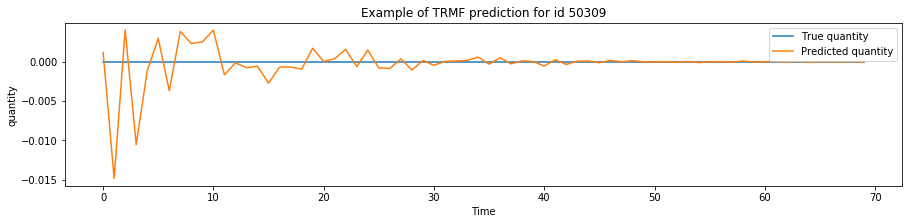

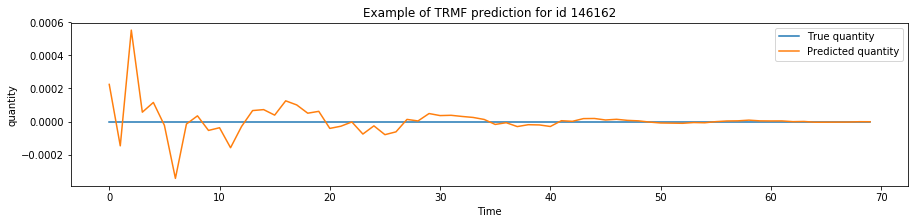

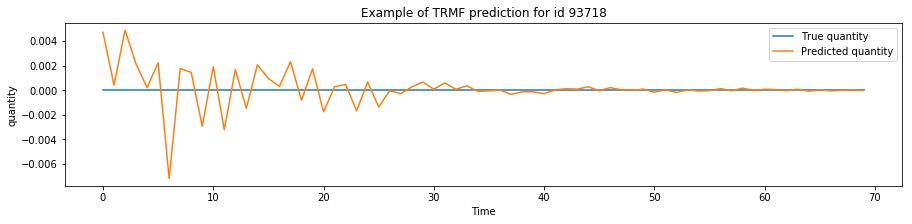

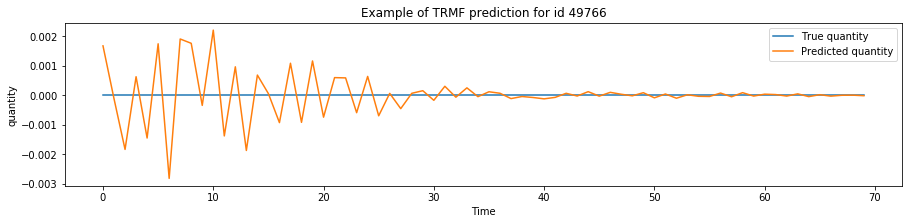

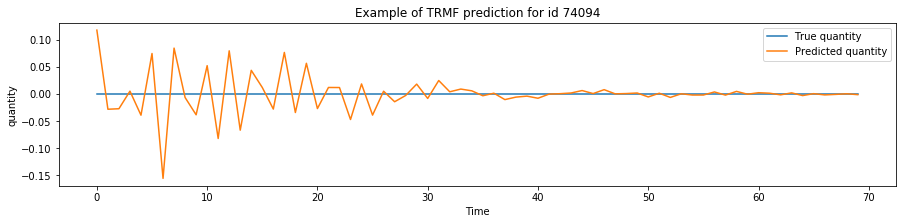

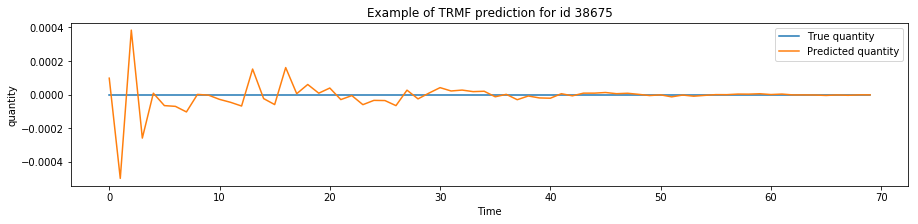

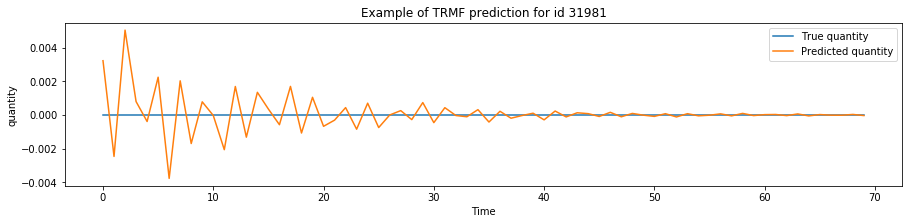

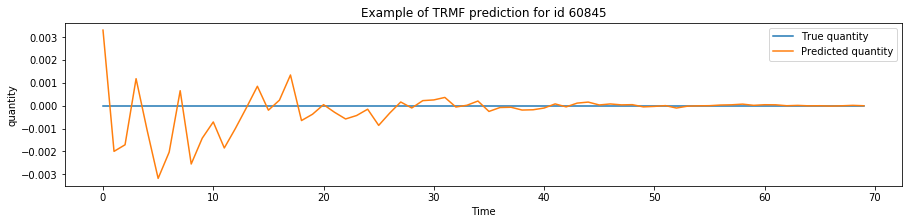

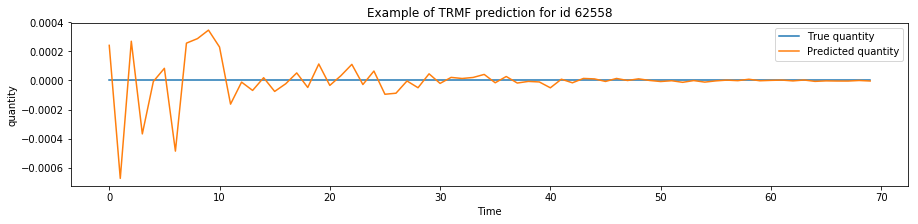

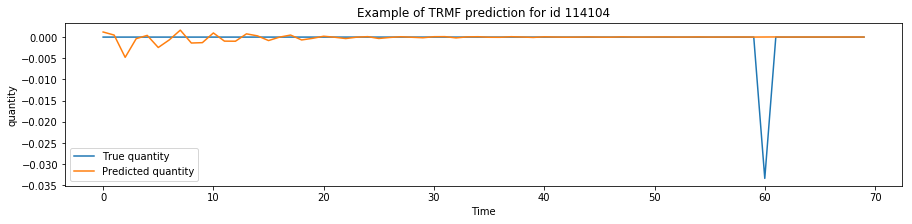

In [366]:
for x in range(10):
    rand = random.choice (test_targets.index)
    fig = plt.figure(figsize=(15,3))
    plt.plot(np.array(test_targets.loc[rand,:]).ravel(), label = 'True quantity')
    plt.plot(np.array(df_prediction.loc[rand,:]).ravel(), label = 'Predicted quantity')
    plt.xlabel('Time')
    plt.ylabel('quantity')
    plt.title('Example of TRMF prediction for id '+str(rand))
    plt.legend(); 